Using device: cpu
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None',

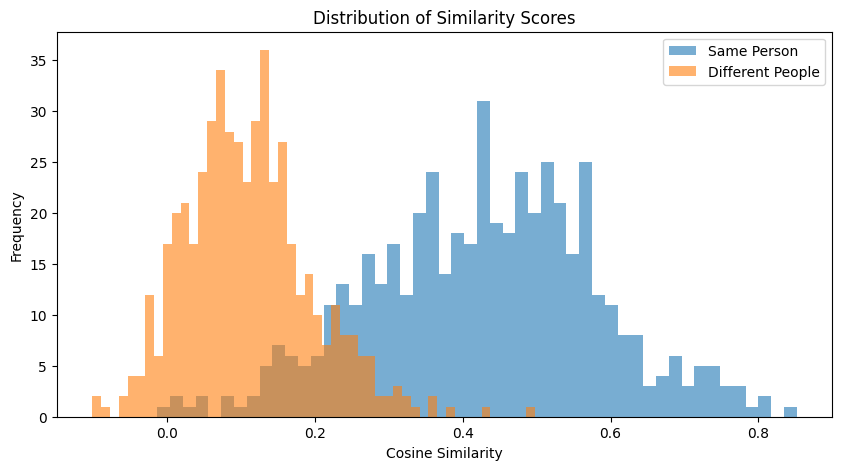

In [4]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tenseal as ts
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from insightface.app import FaceAnalysis

# --------------------------------------------------
#               DEVICE SETUP
# --------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.empty_cache()
print(f"Using device: {device}")

# --------------------------------------------------
#               PART A: EMBEDDINGS
# --------------------------------------------------
base_dir = os.path.join('dataset', 'lfw-deepfunneled', 'lfw-deepfunneled')
pairs_train_path = 'pairsDevTrain.txt'
pairs_test_path = 'pairsDevTest.txt'

# Normalize image filenames
def normalize_name(name):
    return name.replace(' ', '_')

def load_pairs(pairs_path, base_dir):
    pairs = []
    with open(pairs_path, 'r') as f:
        lines = f.readlines()[1:]
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 3:  # Positive pair
                person, img1, img2 = parts
                person = normalize_name(person)
                img1_path = os.path.join(base_dir, person, f"{person}_{int(img1):04d}.jpg")
                img2_path = os.path.join(base_dir, person, f"{person}_{int(img2):04d}.jpg")
                if os.path.exists(img1_path) and os.path.exists(img2_path):
                    pairs.append((img1_path, img2_path, 1))
            elif len(parts) == 4:  # Negative pair
                p1, img1, p2, img2 = parts
                p1, p2 = normalize_name(p1), normalize_name(p2)
                img1_path = os.path.join(base_dir, p1, f"{p1}_{int(img1):04d}.jpg")
                img2_path = os.path.join(base_dir, p2, f"{p2}_{int(img2):04d}.jpg")
                if os.path.exists(img1_path) and os.path.exists(img2_path):
                    pairs.append((img1_path, img2_path, 0))
    return pairs

train_pairs = load_pairs(pairs_train_path, base_dir)
test_pairs = load_pairs(pairs_test_path, base_dir)

# Use ArcFace for feature extraction
app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(112,112))

def get_arcface_embedding(img_path):
    bgr_img = cv2.imread(img_path)
    if bgr_img is None:
        raise ValueError(f"Could not load image: {img_path}")
    bgr_img = cv2.resize(bgr_img, (112, 112))
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    recognition_model = app.models['recognition']
    feat = recognition_model.get_feat(rgb_img)
    feat_norm = feat / np.linalg.norm(feat)
    return feat_norm.astype(np.float32)

def build_embeddings_dict(pairs_list):
    unique_paths = set()
    for (img1, img2, _) in pairs_list:
        unique_paths.add(img1)
        unique_paths.add(img2)
    unique_paths = list(unique_paths)

    emb_dict = {}
    for path in unique_paths:
        emb = get_arcface_embedding(path)  # shape=(512,)
        emb_dict[path] = emb.flatten()
    return emb_dict

emb_dict_train = build_embeddings_dict(train_pairs)
emb_dict_test = build_embeddings_dict(test_pairs)

# --------------------------------------------------
#       PART B: HOMOMORPHIC ENCRYPTION
# --------------------------------------------------
# Set up CKKS encryption context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
context.global_scale = 2**40
context.generate_galois_keys()

# Encrypt embeddings
def encrypt_embeddings(emb_dict):
    encrypted_emb_dict = {}
    for img_path, emb in emb_dict.items():
        encrypted_emb_dict[img_path] = ts.ckks_vector(context, emb)
    return encrypted_emb_dict

encrypted_emb_train = encrypt_embeddings(emb_dict_train)
encrypted_emb_test = encrypt_embeddings(emb_dict_test)

# Homomorphic similarity computation
def homomorphic_cosine_similarity(enc_vec1, enc_vec2):
    dot_product = (enc_vec1 * enc_vec2).sum()
    norm1 = (enc_vec1 * enc_vec1).sum()
    norm2 = (enc_vec2 * enc_vec2).sum()
    decrypted_dot_product = dot_product.decrypt()[0]
    decrypted_norm1 = norm1.decrypt()[0]
    decrypted_norm2 = norm2.decrypt()[0]
    return decrypted_dot_product / (
        (decrypted_norm1 ** 0.5) * (decrypted_norm2 ** 0.5)
    )

# Evaluate homomorphic model
def evaluate_homomorphic_model(pairs, encrypted_emb_dict):
    y_true = []
    y_pred = []

    for img1, img2, label in pairs:
        enc_emb1 = encrypted_emb_dict[img1]
        enc_emb2 = encrypted_emb_dict[img2]
        similarity = homomorphic_cosine_similarity(enc_emb1, enc_emb2)
        y_pred.append(similarity)
        y_true.append(label)

    auc = roc_auc_score(y_true, y_pred)
    print(f"Homomorphic Model AUC: {auc:.4f}")
    return y_true, y_pred

# --------------------------------------------------
#               INTEGRATED MODEL
# --------------------------------------------------
y_true, y_pred = evaluate_homomorphic_model(test_pairs, encrypted_emb_test)

# Plot the similarity scores
plt.figure(figsize=(10, 5))
plt.hist([y_pred[i] for i in range(len(y_pred)) if y_true[i] == 1], bins=50, alpha=0.6, label="Same Person")
plt.hist([y_pred[i] for i in range(len(y_pred)) if y_true[i] == 0], bins=50, alpha=0.6, label="Different People")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Scores")
plt.legend()
plt.show()
